In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt
import os
from pathlib import Path
import time
from data import download
import contextlib
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
from shapely.geometry import Point
import folium
import branca.colormap as cm

import io

with contextlib.redirect_stdout(io.StringIO()):
    data = download()

country_emissions = data['country_emissions']
emissions_sources = data['emissions_sources']
sources_ownership = data['sources_ownership']

#restricting to methane emissions
emissions_sources = emissions_sources.loc[ emissions_sources.gas == 'ch4' ]
emissions_sources = emissions_sources.drop(columns='gas')

#removing non-emitting sources
sum_emissions = emissions_sources.groupby('source_id').sum()[['emissions_quantity']]
non_zero_source = sum_emissions.loc[sum_emissions.emissions_quantity != 0].index.to_list()
emissions_sources = emissions_sources.loc[emissions_sources.source_id.isin(non_zero_source)  ] 

#removing the column "emissions_factor_units"
emissions_sources.rename(columns={'emissions_factor' : 'emissions_factor ' + emissions_sources.emissions_factor_units.unique()[0]}, inplace = True)
emissions_sources.drop(columns='emissions_factor_units', inplace = True)

#Creating a column to create a plot based on average emissions over a depth range
emissions_sources.loc[:, 'rounded Mine Depth'] = emissions_sources['Mine Depth'].apply(lambda x: 50*round(x/50, 0))


In [12]:
emissions_sources_2022 = emissions_sources.loc[emissions_sources.year == 2022][['source_name', 'emissions_factor T of CH4 per T of coal extracted', 'lat', 'lon']]
emissions_sources_2022.rename(columns={'lon' : 'longitude', 'lat' : 'latitude', 'emissions_factor T of CH4 per T of coal extracted' : 'Methane Emissions' }, inplace= True)
df = emissions_sources_2022[['longitude', 'latitude', 'Methane Emissions']]
df.loc[:, 'Methane Emissions'] = 1000*df['Methane Emissions']
df.reset_index(inplace=True)
df=df[['longitude', 'latitude', 'Methane Emissions']]
df['log_Methane Emissions'] = np.log1p(df['Methane Emissions'])

df.head()

longitude   latitude  Methane Emissions  log_Methane Emissions
0  67.312196  35.704992           5.049990               1.800057
1  67.308000  35.733000           5.049990               1.800057
2  67.596674  35.863255          15.374413               2.795720
3  68.120000  35.331940           5.049990               1.800057
4  19.736426  41.391518           5.049990               1.800057

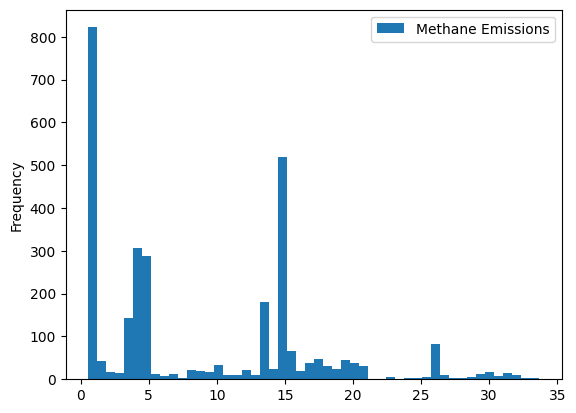

In [26]:
df['Methane Emissions'].plot(kind='hist', bins = 50)
plt.legend()

<Axes: ylabel='Frequency'>

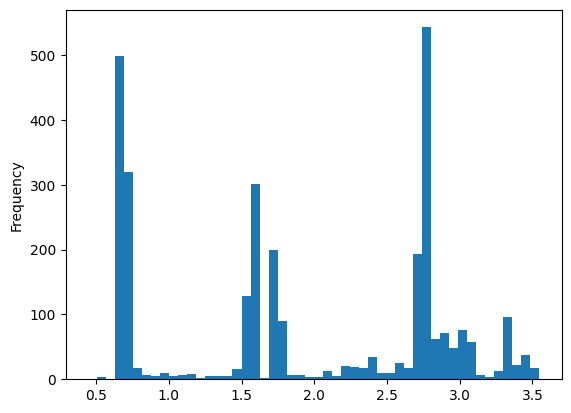

In [25]:
df['log_Methane Emissions'].plot(kind='hist', bins = 50)


In [29]:
m = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=1)

# Create a color map (you can choose any color gradient)
colormap = cm.linear.Reds_09.scale(df['log_Methane Emissions'].min(), df['log_Methane Emissions'].max())
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=df['log_Methane Emissions'].min(), vmax=df['log_Methane Emissions'].max())

for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,  # Size of the marker
        color=colormap(row['log_Methane Emissions']),  # Set color based on intensity
        fill=True,
        fill_color=colormap(row['log_Methane Emissions']),
        fill_opacity=0.7,
        popup=f"Intensity: {row['log_Methane Emissions']}"
    ).add_to(m)

colors = ['green', 'yellow', 'red']
labels = ['Low Emission ratio', 'Medium Emission ratio', 'High Emission ratio']

# Create the legend HTML
legend_html = '''
    <div style="
        position: fixed;
        bottom: 25px;
        left: 25px;
        width: 90px;
        height: auto;
        padding: 1px;
        background: white;
        border: 2px solid black;
        z-index: 9999;
        font-size: 7px;
    ">
        <b>Kilo of Methane per tonne of Coal extracted, log scale</b><br>
        <div style="background-color: green; padding: 2px; color: white;">Low Emission ratio</div>
        <div style="background-color: yellow; padding: 2px;">Medium Emission ratio</div>
        <div style="background-color: red; padding: 2px; color: white;">High Emission ratio</div>
    </div>
'''

# Add the legend to the map using a Marker with a DivIcon
folium.Marker(
    location=[-10, 140],  # Place the marker somewhere off the map view if needed
    icon=folium.DivIcon(html=legend_html)
).add_to(m)

m.save('map_with_legend.html')
m

In [30]:
m = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=1)

# Create a color map (you can choose any color gradient)
colormap = cm.linear.Reds_09.scale(df['Methane Emissions'].min(), df['Methane Emissions'].max())
colormap = cm.LinearColormap(colors=['green', 'yellow', 'red'], vmin=df['Methane Emissions'].min(), vmax=df['Methane Emissions'].max())

for i, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,  # Size of the marker
        color=colormap(row['Methane Emissions']),  # Set color based on intensity
        fill=True,
        fill_color=colormap(row['Methane Emissions']),
        fill_opacity=0.7,
        popup=f"Intensity: {row['Methane Emissions']}"
    ).add_to(m)

colors = ['green', 'yellow', 'red']
labels = ['Low Emission ratio', 'Medium Emission ratio', 'High Emission ratio']

# Create the legend HTML
legend_html = '''
    <div style="
        position: fixed;
        bottom: 25px;
        left: 25px;
        width: 90px;
        height: auto;
        padding: 1px;
        background: white;
        border: 2px solid black;
        z-index: 9999;
        font-size: 7px;
    ">
        <b>Kilo of Methane per tonne of Coal extracted</b><br>
        <div style="background-color: green; padding: 2px; color: white;">Low Emission ratio</div>
        <div style="background-color: yellow; padding: 2px;">Medium Emission ratio</div>
        <div style="background-color: red; padding: 2px; color: white;">High Emission ratio</div>
    </div>
'''

# Add the legend to the map using a Marker with a DivIcon
folium.Marker(
    location=[-10, 140],  # Place the marker somewhere off the map view if needed
    icon=folium.DivIcon(html=legend_html)
).add_to(m)

m.save('map_with_legend.html')
m